In [1]:
from importlib import reload
import sys
sys.path += ["../src"]
import opinion_dynamics_models_estimation as oe
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import pandas as pd
from tqdm import tqdm
import numpy as np
import repeat_function
import simulator_opinion_dynamics as sod
import torch
import torch.nn as nn
from scipy.special import logit
from scipy.special import expit as sigmoid
from initialize_model import EarlyStopping,RandomizeEpsilon,choose_optimizer
from time import time

In [20]:

def choose_optimizer_evidences(optimizer_name, lr, model, X0_lr_scale = 10):
    optimizer_list = ["adam", "SGD", "nadam", "adagrad", "RMSprop"]
    assert optimizer_name in optimizer_list, f"Optimizer must be in {optimizer_list}"
    
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam([
            {'params': model.logit_X0, 'lr': lr * X0_lr_scale},
            {'params': model.theta, 'lr': lr}
        ], lr = lr)
        
        optimizer = torch.optim.Adam([
            {'params': model.logit_X0, 'lr': lr * X0_lr_scale},
            {'params': model.theta, 'lr': lr}
        ], lr = lr) #define the optimizer with the input learning rate
    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD([
            {'params': model.logit_X0, 'lr': lr * X0_lr_scale},
            {'params': model.theta, 'lr': lr}
        ], lr = lr, momentum = 0.9) #define the optimizer with the input learning rate
    if optimizer_name == "nadam":
        optimizer = torch.optim.NAdam([
            {'params': model.logit_X0, 'lr': lr * X0_lr_scale},
            {'params': model.theta, 'lr': lr}
        ], lr = lr) #define the optimizer with the input learning rate        
    if optimizer_name == "adagrad":
        optimizer = torch.optim.Adagrad([
            {'params': model.logit_X0, 'lr': lr * X0_lr_scale},
            {'params': model.theta, 'lr': lr}
        ], lr = lr) #define the optimizer with the input learning rate
    if optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop([
            {'params': model.logit_X0, 'lr': lr * X0_lr_scale},
            {'params': model.theta, 'lr': lr}
        ], lr = lr)
    return optimizer




def count_s_from_edge(e):
    e_unique = e.unique(dim = 0, return_counts = True)
    e_unique[0][:,2] = e_unique[0][:,2] * e_unique[1]
    e_sum_s = e_unique[0]
    return e_sum_s[e_sum_s[:,2] > 0]


def edges_coo_mu(edges, mu, N):
        edges_count_s = [count_s_from_edge(edges[t]) for t in range(len(edges))]
        
        M = [torch.sparse_coo_tensor(indices = edges_count_s[t][:,:2].T, dtype = torch.float32,
                                     values = mu * edges_count_s[t][:,2], 
                                     size = [N, N]) for t in range(len(edges))]
        
        return M
    
def X_from_X0_coo_edges_bf(X0, M_plus, M_minus, mu_plus, mu_minus, T, N):
    X = torch.zeros([T, N], dtype = torch.float32)
    
    X[0] = X0
    for t in range(T - 1):
        updates_plus = mu_plus * ((X[t] * M_plus[t].to_dense()).sum(dim = 1) - (X[t] * M_plus[t].to_dense().T).sum(dim = 0) +\
                   (X[t] * M_plus[t].to_dense().T).sum(dim = 1) - (X[t] * M_plus[t].to_dense()).sum(dim = 0))
        updates_minus = mu_minus * ((X[t] * M_minus[t].to_dense()).sum(dim = 1) - (X[t] * M_minus[t].to_dense().T).sum(dim = 0) +\
                   (X[t] * M_minus[t].to_dense().T).sum(dim = 1) - (X[t] * M_minus[t].to_dense()).sum(dim = 0))
        X[t+1] = torch.clamp(X[t] + updates_plus - updates_minus, 1e-5, 1-1e-5)
    
    return X

    
    """ SBAGLIATO PERCHE NON AGGIORNA CORRETTAMENTE QUANDO X E FUORI RANGE
def X_from_X0_coo_edges_bf(X0, M, T, N):
    X = torch.zeros([T, N], dtype = torch.float32)
    
    X[0] = X0
    for t in range(T - 1):
        updates = ((X[t] * M[t].to_dense()).sum(dim = 1) - (X[t] * M[t].to_dense().T).sum(dim = 0) +\
                   (X[t] * M[t].to_dense().T).sum(dim = 1) - (X[t] * M[t].to_dense()).sum(dim = 0))
        X[t+1] = torch.clamp(X[t] + updates, 1e-5, 1-1e-5)
    
    return X
"""

In [21]:
def kappa_from_epsilon(epsilon, diff_X, rho):
    
    return torch.sigmoid(rho * (epsilon - torch.abs(diff_X)))


In [22]:
class BC_evidence_X_Estimation_bf(nn.Module):
    
    def __init__(self, parameters0, X, edges, evidences):
        
        super().__init__()
        
        epsilon0_plus, epsilon0_minus, mu_plus, mu_minus, rho = parameters0
        self.rho = rho
        self.mu_plus = mu_plus
        self.mu_minus = mu_minus
        
        self.u,self.v, self.s_plus,self.s_minus,self.t = uvst = sod.convert_edges_uvst(edges)

        self.X = X
        self.diff_X = X[self.t,self.u] - X[self.t,self.v]
        _, self.edge_per_t, _ = edges.size()
        self.T, self.N = X.size()
        
        self.M_plus = edges_coo_mu(edges[:,:,[0,1,2]], 1, self.N)
        self.M_minus = edges_coo_mu(edges[:,:,[0,1,3]], 1, self.N)
        #self.M =  M_plus + M_minus
        
        ########
        #edges_count_s = [count_s_from_edge(edges[t]) for t in range(self.T - 1)]
        #self.indices_M = [edges_count_s[t][:,:2].T.long() for t in range(self.T - 1)]
        #self.values_M = [mu * edges_count_s[t][:,2] for t in range(self.T - 1)]
        #######
        
        self.evidences_per_t = len(evidences[0][0])

        self.evidences_indices = torch.cat([evidences[k][0][None,:] for k in range(len(evidences))], dim = 0) #tensor with the indices of the users of which we know the evidence
        self.evidences_opinions = torch.cat([evidences[k][1][None,:] for k in range(len(evidences))], dim = 0).reshape(self.T * self.evidences_per_t).to(torch.float32) #only the evidences of these users
        self.evideneces = evidences
        
        X0 = torch.rand(self.N, dtype = torch.float32, requires_grad = True) # random initialization of the opinions
        self.logit_X0 = nn.Parameter(torch.logit(X0))   #define the parameters of the model
        
        theta = torch.tensor([logit(epsilon0_plus),logit(epsilon0_minus)], requires_grad = True)
        self.theta = nn.Parameter(theta)
        
        
    def forward(self):
        epsilon_plus, epsilon_minus = torch.sigmoid(self.theta)

        X0 = torch.sigmoid(self.logit_X0)   #at each step clip X0 in the interval [0,1]
        X = X_from_X0_coo_edges_bf(X0, self.M_plus, self.M_minus, epsilon_plus, epsilon_minus, self.T, self.N)
        
        #X = X_from_X0_coo_edges(X0, self.indices_M, self.values_M, self.T, self.N)
        
        diff_X = X[self.t,self.u] - X[self.t, self.v] 
        kappa_plus = kappa_from_epsilon(epsilon_plus, diff_X, self.rho)
        kappa_minus = kappa_from_epsilon(epsilon_minus, diff_X, -self.rho) # compute probability of interaction with current estimate of epsilon
        
        return X, kappa_plus, kappa_minus
    
    
    def neg_log_likelihood_function(kappa_plus, kappa_minus, s_plus, s_minus, evidences_indices, evidences_opinions, evidences_per_t, X, t_minibatch):
        T, _ = X.shape
        
        sigmoid_kappa_plus = kappa_plus#torch.sigmoid(kappa)
        sigmoid_kappa_minus = kappa_minus#torch.sigmoid(kappa)
        loss_edges_plus = -torch.sum(torch.log(s_plus * sigmoid_kappa_plus + (1 - s_plus) * (1 - sigmoid_kappa_plus)))
        loss_edges_minus = -torch.sum(torch.log(s_minus * sigmoid_kappa_minus + (1 - s_minus) * (1 - sigmoid_kappa_minus)))
        
        real_opinions = torch.cat([X[t, evidences_indices[t]] for t in range(T)])
        
        loss_evidences = -torch.sum(torch.log(evidences_opinions * real_opinions + (1 - evidences_opinions) * (1 - real_opinions)))
        
        return loss_edges_plus + loss_edges_minus + loss_evidences
    
    def neg_log_likelihood_function_minibatch(kappa_plus, kappa_minus, s_plus, s_minus, evidences_indices, evidences_opinions, evidences_per_t, X, t_minibatch):
        T, _ = X.shape
        
        sigmoid_kappa_plus = kappa_plus#torch.sigmoid(kappa)
        sigmoid_kappa_minus = kappa_minus#torch.sigmoid(kappa)
        loss_edges_plus = -torch.sum(torch.log(s_plus * sigmoid_kappa_plus + (1 - s_plus) * (1 - sigmoid_kappa_plus))[t_minibatch])
        loss_edges_minus = -torch.sum(torch.log(s_minus * sigmoid_kappa_minus + (1 - s_minus) * (1 - sigmoid_kappa_minus))[t_minibatch])
        
        real_opinions = torch.cat([X[t, evidences_indices[t]] for t in range(T)])
        
        loss_evidences = -torch.sum(torch.log(evidences_opinions * real_opinions + (1 - evidences_opinions) * (1 - real_opinions))[t_minibatch])
        
        return loss_edges_plus + loss_edges_minus + loss_evidences


    
def gradient_descent_BC_evidence_X(X, edges, evidences, mu_plus, mu_minus, rho, num_epochs,
                                   epsilon0_plus = 0.25, epsilon0_minus = 0.75, optimizer_name = "adam",
                                   lr = 0.05, patience = 10, min_delta = 1e-6, 
                                   min_epochs = 20, hide_progress = True, minibatch_size = 0):
    u,v, s_plus,s_minus, t = uvst = sod.convert_edges_uvst(edges)
    T,_ = X.shape
    
    model_class = BC_evidence_X_Estimation_bf
    model = model_class((epsilon0_plus, epsilon0_minus, mu_plus, mu_minus, rho), X, edges, evidences)
    if minibatch_size == 0:
        loss_function = model_class.neg_log_likelihood_function
    if minibatch_size > 0:
        loss_function = model_class.neg_log_likelihood_function_minibatch
    
    early_stopping = EarlyStopping(patience, min_delta, min_epochs)
    #optimizer = choose_optimizer(optimizer_name, lr, model)
    optimizer = choose_optimizer_evidences(optimizer_name, lr, model, X0_lr_scale = 10)
    
    history = {"epsilon_plus": [epsilon0_plus], "epsilon_minus": [epsilon0_minus], "loss": [], "X0": []}
    
    t0 = time()
    for epoch in tqdm(range(num_epochs), disable = hide_progress):
        t_minibatch = torch.randperm(T-1)[:minibatch_size]
        
        X_, kappa_plus, kappa_minus = model()
        loss = loss_function(kappa_plus, kappa_minus, model.s_plus, model.s_minus, model.evidences_indices, model.evidences_opinions, 
                             model.evidences_per_t, X_, t_minibatch)
        
        loss.backward()
        optimizer.step()
        
        history["X0"].append(sigmoid(model.logit_X0.detach()))
        history["epsilon_plus"].append(sigmoid(model.theta[0].item()))
        history["epsilon_minus"].append(sigmoid(model.theta[1].item()))
        history["loss"].append(loss.item())
        
        optimizer.zero_grad()
        
        if epoch > min_epochs:
            early_stopping(history["epsilon_plus"][-3], history["epsilon_plus"][-2], history["epsilon_plus"][-1], epoch)
        if early_stopping.early_stop:
            break
            
    t1 = time()
    history["time"] = t1 - t0
    
    return history, X_



In [71]:
N, T, edge_per_t, evidences_per_t = 100, 128, 16, 8
epsilon_plus, epsilon_minus, mu_plus, mu_minus, rho = parameters = (0.16, 0.37, 0.08, 0.03, 16)

In [72]:
X, edges, evidences = sod.simulate_BC(N, T, edge_per_t, evidences_per_t, (parameters), model = "bf")

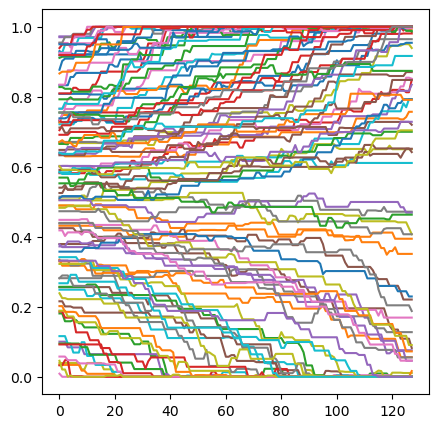

In [73]:
sod.print_opinion_trajectory(X)

In [81]:
num_epochs = 600

history, X_ = gradient_descent_BC_evidence_X(X, edges, evidences, mu_plus, mu_minus, rho, num_epochs,
                                         epsilon0_plus = 0.25, epsilon0_minus = 0.75, optimizer_name = "adam",
                                         lr = 0.01, hide_progress = False, minibatch_size = 0)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [01:01<00:00,  9.81it/s]


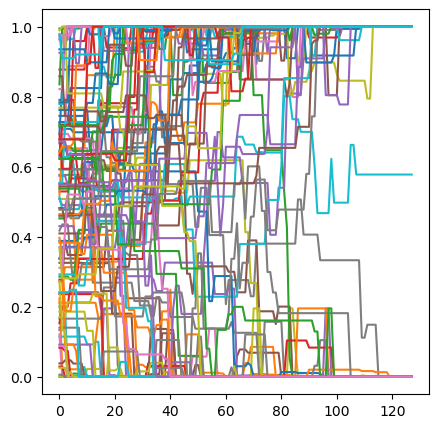

In [82]:
sod.print_opinion_trajectory(X_.detach())

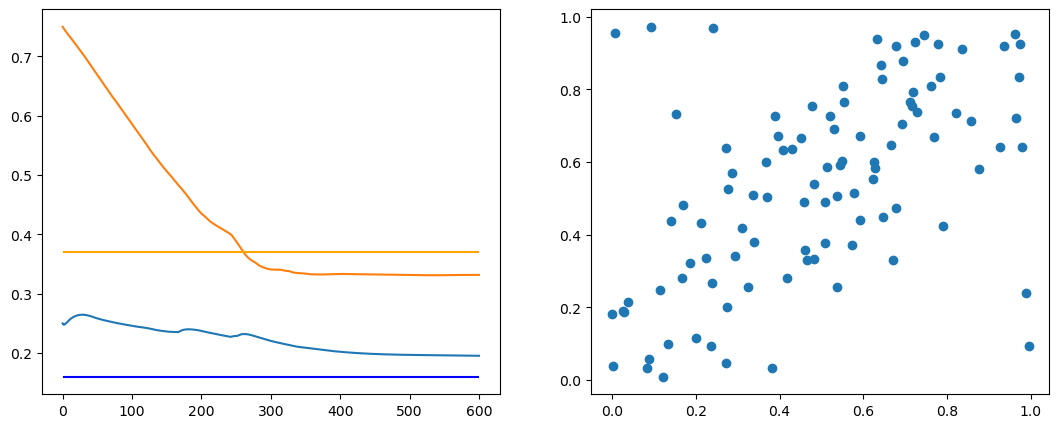

In [83]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
axes[0].plot(history["epsilon_plus"])
axes[0].plot(history["epsilon_minus"])
axes[0].hlines([epsilon_minus, epsilon_plus], xmin = 0, xmax = num_epochs, colors = ["orange", "blue"])
axes[1].plot(history["X0"][-1], X[0], "o")

In [84]:
history["epsilon_plus"][-1], epsilon_plus, history["epsilon_minus"][-1], epsilon_minus

(0.19538697778998085, 0.16, 0.33176964568790807, 0.37)